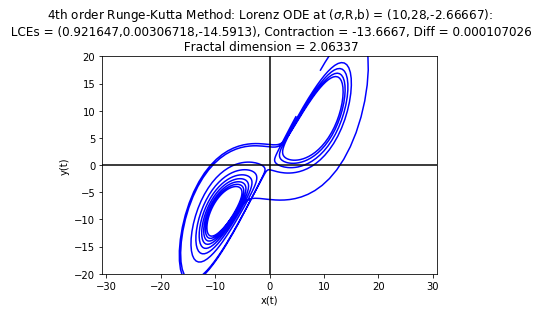

In [27]:
# LorenzODELCE.py:
#   Estimate the spectrum of Lyapunov Characteristic Exponents
#	  for the Lorenz ODEs, using the pull-back method.
#   Also, estimate the volume-contraction (dissipation) rate and the
#	   fractal dimenion (latter using the Kaplan-Yorke conjecture).
#   Plot out trajectory, for reference.
#
# Comment:
#	Notice how much more complicated the code has become, given
#		that we're writing out variables in component form.
#   This should be rewritten to use vectors, which will be
#	   much more compact and easier to debug. Equally important,
#      the code would generalize to any dimension system.

# Import plotting routines
from pylab import *

# The Lorenz 3D ODEs
#	Original parameter values: (sigma,R,b) = (10,28,-8/3)
def LorenzXDot(sigma,R,b,x,y,z):
	return sigma * (-x + y)

def LorenzYDot(sigma,R,b,x,y,z):
	return R*x - x*z - y

def LorenzZDot(sigma,R,b,x,y,z):
	return b*z + x*y

# The tangent space (linearized) flow (aka co-tangent flow)
def LorenzDXDot(sigma,R,b,x,y,z,dx,dy,dz):
	return sigma * (-dx + dy)

def LorenzDYDot(sigma,R,b,x,y,z,dx,dy,dz):
	return (R-z)*dx - dy - x*dz

def LorenzDZDot(sigma,R,b,x,y,z,dx,dy,dz):
	return y*dx + x*dy + b*dz

# Volume contraction given by
#	 Trace(Jacobian(x,y,z)) = b - sigma - 1
def LorenzODETrJac(sigma,R,b,x,y,z):
	return b - sigma - 1
# As a check, we must have total contraction = Sum of LCEs
#	 Tr(J) = Sum_i LCEi
# Numerical check: at (sigma,R,b) = (10,28,-8/3)
#	 LCE0  ~   0.9058
#	 LCE1  ~   0.0000
#	 LCE2  ~ -14.572
#	 Tr(J) ~ -13.6666
# These use base-2 logs

# The fractal dimension from the LCEs (Kaplan-Yorke conjecture)
#   Assume these are ordered: LCE1 >= LCE2 >= LCE3
def FractalDimension3DODE(LCE1,LCE2,LCE3):
	# "Close" to zero ... we're estimating here
	Err = 0.01
	if LCE1 < -Err:	  # Stable fixed point    (-,-,-)
		return 0.0
	elif abs(LCE1) <= Err:
		if LCE2 < -Err:  # Limit cycle	      (0,-,-)
			return 1.0
		else:	        # Torus               (0,0,-)
			return 2.0
	else:	            # Chaotic attractor   (+,0,-)
		return 2.0 + (LCE1+LCE2) / abs(LCE3)

# 3D fourth-order Runge-Kutta integrator
def RKThreeD(a,b,c,x,y,z,f,g,h,dt):
	k1x = dt * f(a,b,c,x,y,z)
	k1y = dt * g(a,b,c,x,y,z)
	k1z = dt * h(a,b,c,x,y,z)
	k2x = dt * f(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k2y = dt * g(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k2z = dt * h(a,b,c,x + k1x / 2.0,y + k1y / 2.0,z + k1z / 2.0)
	k3x = dt * f(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k3y = dt * g(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k3z = dt * h(a,b,c,x + k2x / 2.0,y + k2y / 2.0,z + k2z / 2.0)
	k4x = dt * f(a,b,c,x + k3x,y + k3y,z + k3z)
	k4y = dt * g(a,b,c,x + k3x,y + k3y,z + k3z)
	k4z = dt * h(a,b,c,x + k3x,y + k3y,z + k3z)
	x += ( k1x + 2.0 * k2x + 2.0 * k3x + k4x ) / 6.0
	y += ( k1y + 2.0 * k2y + 2.0 * k3y + k4y ) / 6.0
	z += ( k1z + 2.0 * k2z + 2.0 * k3z + k4z ) / 6.0
	return x,y,z

# Tanget space flow (using fourth-order Runge-Kutta integrator)
def TangentFlowRKThreeD(a,b,c,x,y,z,df,dg,dh,dx,dy,dz,dt):
	k1x = dt * df(a,b,c,x,y,z,dx,dy,dz)
	k1y = dt * dg(a,b,c,x,y,z,dx,dy,dz)
	k1z = dt * dh(a,b,c,x,y,z,dx,dy,dz)
	k2x = dt * df(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k2y = dt * dg(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k2z = dt * dh(a,b,c,x,y,z,dx+k1x/2.0,dy+k1y/2.0,dz+k1z/2.0)
	k3x = dt * df(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k3y = dt * dg(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k3z = dt * dh(a,b,c,x,y,z,dx+k2x/2.0,dy+k2y/2.0,dz+k2z/2.0)
	k4x = dt * df(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	k4y = dt * dg(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	k4z = dt * dh(a,b,c,x,y,z,dx+k3x,dy+k3y,dz+k3z)
	dx += ( k1x + 2.0 * k2x + 2.0 * k3x + k4x ) / 6.0
	dy += ( k1y + 2.0 * k2y + 2.0 * k3y + k4y ) / 6.0
	dz += ( k1z + 2.0 * k2z + 2.0 * k3z + k4z ) / 6.0
	return dx,dy,dz

# Simulation parameters
# Integration time step
dt = 0.01
#
# Control parameters for the Lorenz ODEs:
sigma = 10.0
R	  = 28.0
b	  = -8.0/3.0
# The number of iterations to throw away
nTransients = 10
# The number of time steps to integrate over
nIterates = 1000

# The main loop that generates the orbit, storing the states
xState = 5.0
yState = 5.0
zState = 5.0
# Iterate for some number of transients, but don't use these states
for n in range(0,nTransients):
	xState,yState,zState = RKThreeD(sigma,R,b,xState,yState,zState,LorenzXDot,LorenzYDot,LorenzZDot,dt)
# Set up array of iterates and store the current state
x = [xState]
y = [yState]
z = [zState]
for n in range(0,nIterates):
	# at each time step calculate new (x,y,z)(t)
	xt,yt,zt = RKThreeD(sigma,R,b,x[n],y[n],z[n],LorenzXDot,LorenzYDot,LorenzZDot,dt)
	# and append to lists
	x.append(xt)
	y.append(yt)
	z.append(zt)

# Estimate the LCEs
# The number of iterations to throw away
nTransients = 100
# The number of iterations to over which to estimate
#  This is really the number of pull-backs
nIterates = 1000
# The number of iterations per pull-back
nItsPerPB = 10
# Initial condition
xState = 5.0
yState = 5.0 
zState = 5.0 
# Initial tangent vectors
e1x = 1.0
e1y = 0.0
e1z = 0.0
e2x = 0.0
e2y = 1.0
e2z = 0.0
e3x = 0.0
e3y = 0.0
e3z = 1.0
# Iterate away transients and let the tangent vectors align
#	with the global stable and unstable manifolds
for n in range(0,nTransients):
	for i in range(nItsPerPB):
		xState,yState,zState = RKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzXDot,LorenzYDot,LorenzZDot,dt)
		# Evolve tangent vector for maximum LCE (LCE1)
		e1x,e1y,e1z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e1x,e1y,e1z,dt)
		# Evolve tangent vector for next LCE (LCE2)
		e2x,e2y,e2z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e2x,e2y,e2z,dt)
		# Evolve tangent vector for last LCE
		e3x,e3y,e3z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e3x,e3y,e3z,dt)
	# Normalize the tangent vector
	d = sqrt(e1x*e1x + e1y*e1y + e1z*e1z)
	e1x /= d
	e1y /= d
	e1z /= d
	# Pull-back: Remove any e1 component from e2
	dote1e2 = e1x * e2x + e1y * e2y + e1z * e2z
	e2x -= dote1e2 * e1x
	e2y -= dote1e2 * e1y
	e2z -= dote1e2 * e1z
	# Normalize second tangent vector
	d = sqrt(e2x*e2x + e2y*e2y + e2z*e2z)
	e2x /= d
	e2y /= d
	e2z /= d
	# Pull-back: Remove any e1 and e2 components from e3
	dote1e3 = e1x * e3x + e1y * e3y + e1z * e3z
	dote2e3 = e2x * e3x + e2y * e3y + e2z * e3z
	e3x -= dote1e3 * e1x + dote2e3 * e2x
	e3y -= dote1e3 * e1y + dote2e3 * e2y
	e3z -= dote1e3 * e1z + dote2e3 * e2z
	# Normalize third tangent vector
	d = sqrt(e3x*e3x + e3y*e3y + e3z*e3z)
	e3x /= d
	e3y /= d
	e3z /= d

# Okay, now we're ready to begin the estimation
LCE1 = 0.0
LCE2 = 0.0
LCE3 = 0.0
for n in range(0,nIterates):
	for i in range(nItsPerPB):
		xState,yState,zState = RKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzXDot,LorenzYDot,LorenzZDot,dt)
		# Evolve tangent vector for maximum LCE (LCE1)
		e1x,e1y,e1z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e1x,e1y,e1z,dt)
		# Evolve tangent vector for next LCE (LCE2)
		e2x,e2y,e2z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e2x,e2y,e2z,dt)
		# Evolve tangent vector for last LCE
		e3x,e3y,e3z = TangentFlowRKThreeD(sigma,R,b,xState,yState,zState,\
			LorenzDXDot,LorenzDYDot,LorenzDZDot,e3x,e3y,e3z,dt)
	# Normalize the tangent vector
	d = sqrt(e1x*e1x + e1y*e1y + e1z*e1z)
	e1x /= d
	e1y /= d
	e1z /= d
	# Accumulate the first tangent vector's length change factor
	LCE1 += log(d)
	# Pull-back: Remove any e1 component from e2
	dote1e2 = e1x * e2x + e1y * e2y + e1z * e2z
	e2x -= dote1e2 * e1x
	e2y -= dote1e2 * e1y
	e2z -= dote1e2 * e1z
	# Normalize second tangent vector
	d = sqrt(e2x*e2x + e2y*e2y + e2z*e2z)
	e2x /= d
	e2y /= d
	e2z /= d
	# Accumulate the second tangent vector's length change factor
	LCE2 += log(d)
	# Pull-back: Remove any e1 and e2 components from e3
	dote1e3 = e1x * e3x + e1y * e3y + e1z * e3z
	dote2e3 = e2x * e3x + e2y * e3y + e2z * e3z
	e3x -= dote1e3 * e1x + dote2e3 * e2x
	e3y -= dote1e3 * e1y + dote2e3 * e2y
	e3z -= dote1e3 * e1z + dote2e3 * e2z
	# Normalize third tangent vector
	d = sqrt(e3x*e3x + e3y*e3y + e3z*e3z)
	e3x /= d
	e3y /= d
	e3z /= d
	# Accumulate the third tangent vector's length change factor
	LCE3 += log(d)

# Convert to per-iterate, per-second LCEs and to base-2 logs
IntegrationTime = dt * float(nItsPerPB) * float(nIterates)
LCE1 = LCE1 / IntegrationTime
LCE2 = LCE2 / IntegrationTime
LCE3 = LCE3 / IntegrationTime
# Calculate contraction factor, for comparison.
#	For Lorenz ODE, we know this is independent of (x,y,z).
#	Otherwise, we'd have to estimate it along the trajectory, too.
Contraction = LorenzODETrJac(sigma,R,b,0.0,0.0,0.0)

# Choose a pair of coordinates from (x,y,z) to show
# Setup the parametric plot:
xlabel('x(t)') # set x-axis label
ylabel('y(t)') # set y-axis label
# Construct plot title
LCEString = '(%g,%g,%g)' % (LCE1,LCE2,LCE3)
PString = '($\sigma$,R,b) = (%g,%g,%g)' % (sigma,R,b)
CString = 'Contraction = %g, Diff = %g' % (Contraction,abs(LCE1+LCE2+LCE3-Contraction))
FString   = 'Fractal dimension = %g' % FractalDimension3DODE(LCE1,LCE2,LCE3)
title('4th order Runge-Kutta Method: Lorenz ODE at ' + PString + ':\n LCEs = ' + LCEString + ', ' + CString + '\n ' + FString)
axis('equal')
axis([-20.0,20.0,-20.0,20.0])
# Plot the trajectory in the phase plane
plot(x,y,'b')
axhline(0.0,color = 'k')
axvline(0.0,color = 'k')

# Use command below to save figure
#savefig('LorenzODELCE', dpi=600)

# Display the plot in a window
show()

In [30]:
print('Lyapunov Characteristic Exponents are ', LCEString)

Lyapunov Characteristic Exponents are  (0.921647,0.00306718,-14.5913)


In [1]:
import subprocess